## Import Library

In [1]:
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType, TimestampNTZType

## Define Functions

In [34]:
def merge_data(spark: SparkSession, output_dir: str, start_date: str, end_date: str):
    sy, sm = start_date.split('-')
    ey, em = end_date.split('-')
    tmp_df = []
    for year in range(int(sy), int(ey)+1):
        for month in range(1, 13):
            if year == int(sy) and month < int(sm):
                continue
            if year == int(ey) and month > int(em):
                continue
            file_path = f'{output_dir}/fhvhv_tripdata_{year}-{str(month).zfill(2)}.parquet'
            tmp_df.append(spark.read.parquet(file_path))

    if len(tmp_df) == 1:
        return tmp_df[0]
    return tmp_df[0].union(*tmp_df[1:])

In [35]:
def remove_missing_values(df):
    df = df.na.drop()
    return df

In [36]:
def fill_missing_values(df):
    # mode_value = df.groupBy(col).count().orderBy($"count".desc).first()[0] # spark-shell
    for col in df.columns:
        try:
            mode_value = df.groupBy(col).count().orderBy(
                F.col("count").desc()).first()[0]
            df = df.na.fill({col: mode_value})
        except:
            df = df.na.drop(subset=[col])
    return df


In [37]:
def preprocess_msvalue(df, method: str):
    if method == 'remove':
        return remove_missing_values(df)
    elif method == 'fill':
        return fill_missing_values(df)
    else:
        raise ValueError(f"Unknown method: {method}")


In [38]:
def convert_time_to_timestamp(df):
    for col in df.columns:
        dtype = df.schema[col].dataType
        if isinstance(dtype, TimestampNTZType):
            df = df.withColumn(col, F.date_format(
                col, 'yyyy-MM-dd HH:mm:ss'))

    return df

In [39]:
def remove_invalid_values(df):
    for col in df.columns:
        if isinstance(df.schema[col].dataType, NumericType):
            df = df.withColumn(col, F.when(
                F.col(col) >= 0, F.col(col)).otherwise(None))
            df = df.na.drop(subset=[col])
    return df

In [40]:
def calculate_trip_avg_duration(df):
    avg_trip_time = df.select(F.avg(F.col("trip_time").cast(
        "long")).alias("avg_trip_time")).collect()[0][0]
    # avg_time_df = df.groupBy('trip_time').agg(F.avg('trip_duration').alias('trip_avg_duration'))
    return avg_trip_time


In [41]:
def calculate_trip_avg_distance(df):
    avg_dist_time = df.select(F.avg(F.col("trip_miles").cast(
        "long")).alias("avg_trip_dist")).collect()[0][0]
    return avg_dist_time

In [42]:
def calculate_peak_hours(df):
    df = df.withColumn("hour", F.hour("pickup_datetime"))  # extract hour from timestamp
    hourly_trips_df = df.groupBy("hour").count().orderBy("hour")
    return hourly_trips_df

In [43]:
def vis_peak_hours(spark_df):
    # Collect the results to a list of rows
    results = spark_df.collect()
    
    # Extract hours and counts
    hours = [row['hour'] for row in results]
    counts = [row['count'] for row in results]
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(hours, counts, color='skyblue')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title('Distribution of Trips Across Different Hours of the Day')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')
    
    # Identify peak hours
    max_count = max(counts)
    peak_hours = [hours[i] for i in range(len(counts)) if counts[i] == max_count]
    
    # Annotate the bars and highlight peak hours
    for i in range(len(hours)):
        plt.text(hours[i], counts[i], str(round(counts[i]/1000)) + 'K', ha='center', va='bottom')
        if hours[i] in peak_hours:
            plt.gca().patches[i].set_color('orange')
    
    plt.tight_layout()
    plt.show()

In [44]:
def save_dataframe_to_hdfs(df):
    df = df.coalesce(1)
    df.write.csv(result_dir, header=True, mode='overwrite')

## Run SparkSession

In [45]:
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

output_dir = "hdfs://hadoop-single:9000/data"
result_dir = "hdfs://hadoop-single:9000/result"
start_date = "2023-01"
end_date = "2023-01"

In [46]:
# load dataframe from hdfs
df = merge_data(spark, output_dir, start_date, end_date)

In [47]:
# remove rows which have missing value
print("Total Counts Before Remove Missing Values From DataFrame: ", df.count())
df = preprocess_msvalue(df, "remove")
print("Total Counts After Remove Missing Values From DataFrame: ", df.count())

Total Counts Before Remove Missing Values From DataFrame:  18479031


Total Counts After Remove Missing Values From DataFrame:  13587039


In [48]:
# convert timestamp
df = convert_time_to_timestamp(df)

In [49]:
# remove invalid values
print("Total Counts Before Remove Invalid Values from DataFrame: ", df.count())
df = remove_invalid_values(df)
print("Total Counts After Remove Invalid Values from DataFrame: ", df.count())


Total Counts Before Remove Invalid Values from DataFrame:  13587039


Total Counts After Remove Invalid Values from DataFrame:  13573583


In [50]:
# calculate trip avg time/distance
avg_time = calculate_trip_avg_duration(df)
avg_dist = calculate_trip_avg_distance(df)

In [51]:
print("Average trip time:", round(avg_time, 2), "seconds")
print("Average trip distance:", round(avg_dist, 2), "miles")

Average trip time: 1100.75 seconds
Average trip distance: 4.42 miles


In [52]:
# find peak_hour and vis
hourly_trips_df = calculate_peak_hours(df)

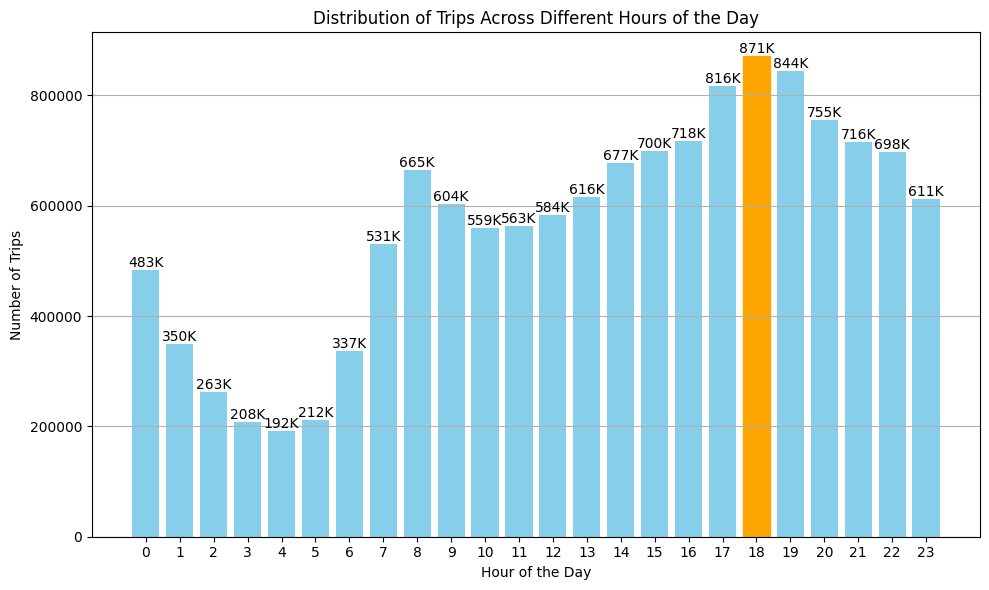

In [53]:
vis_peak_hours(hourly_trips_df)

In [23]:
# 전처리된 데이터 저장을 위한 HDFS 명령어 실행
save_dataframe_to_hdfs(df)

### Load Weather Data

In [62]:
ndf = spark.read.csv(output_dir+"/us_time.csv")

In [63]:
first_row = ndf.first()
columns = [str(cell) for cell in first_row]

# 첫 번째 행을 제외한 데이터 로드
ndf = ndf.filter(ndf['_c0'] != first_row[0])
ndf = ndf.toDF(*columns)

### Preprocess Weather Data (avg temp, hum, ..)

- 타겟을 뭘로 할까? => 강수량 / 온도 / 습도 / 풍량 정도의 데이터를 추출해보고자 함. 
- 동일한 row가 존재할 수 있기에, 중복을 제거하는 과정을 거친다.
- 강수량의 컬럼은 AA1/AA2/...이며, 특정 시간대에는 강수량이 두번 이상 측정되는 경우가 있음. (01, 0003, 9, 5) -> 1시간 동안의 강수량이 0.3mm이다 라는 뜻
- 실제 데이터는 UTC 데이터를 기준으로 하기에, NYC는 UTC를 기준으로 4시간이 느리다 => 변경해줘야 정확한 시간 비교가 가능함.
- 온도(TMP)는 0078로 표기되며, => 7.8'C를 의미함. +9999 => 누락 값.
- WND는 (direc, direc_quality, observe type, speed, speed_quality)로 구성되며, (170, 1, N, 0015, 1)일 경우 풍향이 170도이며 속도가 초당 1.5m임을 의미함. 여기 또한 +9999는 누락값.

데이터 생성

In [64]:
not_use_cols = ['NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'CIG', 'VIS', 'DEW', 'SLP', 'AA2', 'AA3', 'AB1', 'AD1', 'AE1', 'AH1', 'AH2', 'AH3', 
                'AH4', 'AH5', 'AH6', 'AI1', 'AI2', 'AI3', 'AI4', 'AI5', 'AI6', 'AJ1', 'AK1', 'AL1', 'AM1', 'AN1', 'AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AU1',
                'AU2', 'AW1', 'AW2', 'AW3', 'AX1', 'AX2', 'AX3', 'AX4', 'GA1', 'GA2', 'GA3', 'GD1', 'GD2', 'GD3', 'GE1', 'GF1', 'KA1', 'KA2', 'KB1', 'KB2',
                'KB3', 'KC1', 'KC2', 'KD1', 'KD2', 'KE1', 'KG1', 'KG2', 'MA1', 'MD1', 'MF1', 'MG1', 'MH1', 'MK1', 'MW1', 'OC1', 'OD1', 'OE1', 'OE2', 'OE3',
                'RH1', 'RH2', 'RH3', 'WA1', 'REM', 'EQD', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

In [65]:
for col_name in not_use_cols:
    ndf = ndf.drop(col_name)

In [66]:
# TMP / WND 전처리
ndf = ndf.withColumn('Temperature(C)', F.regexp_extract('TMP', r'(\+|-)?\d{4}', 0).cast('int') / 10) # 섭씨 온도
ndf = ndf.withColumn('Wind_Power(m/s)', F.regexp_extract('WND', r'\d{3},\d,[A-Z],(\d{4})', 1).cast('int') / 10) # 풍속

In [67]:
# UTC => 실제 뉴욕 시간으로 변경
ndf = ndf.withColumn('DATE', F.col('DATE').cast('timestamp'))
ndf = ndf.withColumn('DATE', F.col('DATE') - F.expr('INTERVAL 4 HOURS'))

In [68]:
# 강수량 전처리
ndf = ndf.withColumn('RAIN_PER_HOUR', F.regexp_extract('AA1', r'\d{2},(\d{4})', 1).cast('int') / 10) # 강수량

In [69]:
# 일별 시간대 컬럼 추가
ndf = ndf.withColumn('DAY', F.dayofmonth(F.col('DATE')))
ndf = ndf.withColumn('HOUR', F.hour(F.col('DATE')))
ndf = ndf.withColumn('MONTH', F.month(F.col('DATE'))) 
ndf = ndf.withColumn('Year', F.year(F.col('DATE')))

데이터 전처리

In [70]:
# DATE가 동일한 컬럼 제거
print("Before count:", ndf.count())
ndf = ndf.dropDuplicates(['DATE'])
print("After count:", ndf.count())

Before count: 11842
After count: 11824


In [71]:
# temperature 결측치 처리
ndf = ndf.withColumn('Temperature(C)', F.when(F.col('Temperature(C)') == 999.9, None).otherwise(F.col('Temperature(C)')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
ndf = ndf.withColumn('Temperature(C)', F.when(F.col('Temperature(C)').isNull(), F.avg('Temperature(C)').over(window_spec)).otherwise(F.col('Temperature(C)')))

In [72]:
# wind_power 결측치 처리
ndf = ndf.withColumn('Wind_Power(m/s)', F.when(F.col('Wind_Power(m/s)') == 999.9, None).otherwise(F.col('Wind_Power(m/s)')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
ndf = ndf.withColumn('Wind_Power(m/s)', F.when(F.col('Wind_Power(m/s)').isNull(), F.avg('Wind_Power(m/s)').over(window_spec)).otherwise(F.col('Wind_Power(m/s)')))

In [73]:
# RAIN_PER_HOUR
ndf = ndf.withColumn('RAIN_PER_HOUR', F.when(F.col('RAIN_PER_HOUR') == 999.9, None).otherwise(F.col('RAIN_PER_HOUR')))
window_spec = Window.partitionBy('STATION').orderBy('DATE').rowsBetween(-3, 3)
ndf = ndf.withColumn('RAIN_PER_HOUR', F.when(F.col('RAIN_PER_HOUR').isNull(), F.avg('RAIN_PER_HOUR').over(window_spec)).otherwise(F.col('RAIN_PER_HOUR')))

In [74]:
ndf.select('DATE', 'TMP', 'WND', 'AA1', 'Temperature(C)', 'Wind_Power(m/s)', 'RAIN_PER_HOUR').show(20, truncate=False)

+-------------------+-------+--------------+-----------+------------------+------------------+------------------+
|DATE               |TMP    |WND           |AA1        |Temperature(C)    |Wind_Power(m/s)   |RAIN_PER_HOUR     |
+-------------------+-------+--------------+-----------+------------------+------------------+------------------+
|2022-12-31 20:06:00|+0100,5|999,9,C,0000,5|01,0000,2,1|10.0              |0.0               |0.0               |
|2022-12-31 20:18:00|+0100,5|030,5,N,0015,5|01,0000,2,1|10.0              |1.5               |0.0               |
|2022-12-31 20:31:00|+0100,5|999,9,C,0000,5|01,0002,3,1|10.0              |0.0               |0.2               |
|2022-12-31 20:44:00|+0100,5|999,9,C,0000,5|01,0005,3,1|10.0              |0.0               |0.5               |
|2022-12-31 20:49:00|+0100,5|999,9,C,0000,5|null       |10.0              |0.0               |0.4166666666666667|
|2022-12-31 20:51:00|+0100,5|999,9,C,0000,5|01,0008,9,5|10.0              |0.0          

In [75]:
average_df = ndf.groupBy('Year', 'Month', 'Day', 'Hour').agg(
    F.round(F.avg('Temperature(C)'), 2).alias('Avg_temp(C)'),
    F.round(F.avg('Wind_Power(m/s)'), 2).alias('Avg_wind_power(m/s)'),
    F.round(F.avg('RAIN_PER_HOUR'), 2).alias('Avg_rain_per_hour(mm)')
).orderBy('Year', 'Month', 'Day', 'Hour')

In [76]:
average_df.show(20)

+----+-----+---+----+-----------+-------------------+---------------------+
|Year|Month|Day|Hour|Avg_temp(C)|Avg_wind_power(m/s)|Avg_rain_per_hour(mm)|
+----+-----+---+----+-----------+-------------------+---------------------+
|2022|   12| 31|  20|       10.0|               0.25|                 0.32|
|2022|   12| 31|  21|       11.7|               1.53|                 0.67|
|2022|   12| 31|  22|       12.1|                1.3|                 1.92|
|2022|   12| 31|  23|       12.6|                2.6|                 0.77|
|2023|    1|  1|   0|      12.19|               1.27|                 1.85|
|2023|    1|  1|   1|      12.02|               1.95|                  0.3|
|2023|    1|  1|   2|       11.7|                3.6|                  0.0|
|2023|    1|  1|   3|       11.1|                2.6|                  0.0|
|2023|    1|  1|   4|       11.7|                4.1|                  0.0|
|2023|    1|  1|   5|       11.1|                2.1|                  0.0|
|2023|    1|

### Merge Preprocessed Dataframe and Weather Dataframe

In [130]:
df = df.withColumn('Year', F.year(F.col('request_datetime')))
df = df.withColumn('Month', F.month(F.col('request_datetime')))
df = df.withColumn('Day', F.dayofmonth(F.col('request_datetime')))
df = df.withColumn('Hour', F.hour(F.col('request_datetime')))

In [131]:
merged_df = df.join(average_df, on=['Year', 'Month', 'Day', 'Hour'])

In [ ]:
## 기온 구간 별 평균 여행객 수 계산
merged_df = merged_df.withColumn(
    'temp_bin',
    F.when(F.col('Avg_temp(C)') < 0, 'Below 0')
     .when((F.col('Avg_temp(C)') >= 0) & (F.col('Avg_temp(C)') < 10), '0-10')
     .when((F.col('Avg_temp(C)') >= 10) & (F.col('Avg_temp(C)') < 20), '10-20')
     .when((F.col('Avg_temp(C)') >= 20) & (F.col('Avg_temp(C)') < 30), '20-30')
     .otherwise('Above 30')
)

# 그룹화
temp_bin_trip_count = merged_df.groupBy('temp_bin').agg(
    F.count('hvfhs_license_num').alias('trip_count')
)

temp_bin_trip_count_data = temp_bin_trip_count.collect()

# 데이터 추출
temp_bins = [row['temp_bin'] for row in temp_bin_trip_count_data]
trip_counts = [row['trip_count'] for row in temp_bin_trip_count_data]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(temp_bins, trip_counts, color='skyblue')
plt.xlabel('Temperature Bin')
plt.ylabel('Trip Count')
plt.title('Trip Count by Temperature Bin')

max_count = max(trip_counts)
peak = [temp_bins[i] for i in range(len(trip_counts)) if trip_counts[i] == max_count]

# Annotate the bars and highlight peak hours
for i in range(len(temp_bins)):
    plt.text(temp_bins[i], trip_counts[i], str(round(trip_counts[i]/1000)) + 'K', ha='center', va='bottom')
    if temp_bins[i] in peak:
        plt.gca().patches[i].set_color('orange')

plt.show()

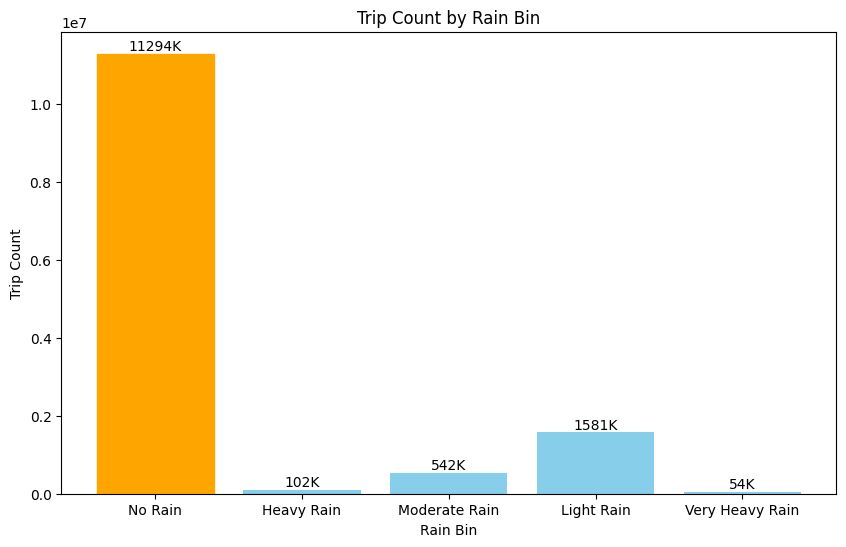

In [138]:
## 바람 세기 구간 별 평균 여행객 수 계산
merged_df = merged_df.withColumn(
    'rain_bin',
    F.when(F.col('Avg_rain_per_hour(mm)') == 0, 'No Rain')
     .when((F.col('Avg_rain_per_hour(mm)') > 0) & (F.col('Avg_rain_per_hour(mm)') <= 1), 'Light Rain')
     .when((F.col('Avg_rain_per_hour(mm)') > 1) & (F.col('Avg_rain_per_hour(mm)') <= 5), 'Moderate Rain')
     .when((F.col('Avg_rain_per_hour(mm)') > 5) & (F.col('Avg_rain_per_hour(mm)') <= 10), 'Heavy Rain')
     .otherwise('Very Heavy Rain')
)

# 그룹화
rain_bin_trip_count = merged_df.groupBy('rain_bin').agg(
    F.count('hvfhs_license_num').alias('trip_count')
)

rain_bin_trip_count_data = rain_bin_trip_count.collect()

# 데이터 추출
rain_bins = [row['rain_bin'] for row in rain_bin_trip_count_data]
trip_counts = [row['trip_count'] for row in rain_bin_trip_count_data]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(rain_bins, trip_counts, color='skyblue')
plt.xlabel('Rain Bin')
plt.ylabel('Trip Count')
plt.title('Trip Count by Rain Bin')

max_count = max(trip_counts)
peak = [rain_bins[i] for i in range(len(trip_counts)) if trip_counts[i] == max_count]

# Annotate the bars and highlight peak hours
for i in range(len(rain_bins)):
    plt.text(rain_bins[i], trip_counts[i], str(round(trip_counts[i]/1000)) + 'K', ha='center', va='bottom')
    if rain_bins[i] in peak:
        plt.gca().patches[i].set_color('orange')

plt.show()

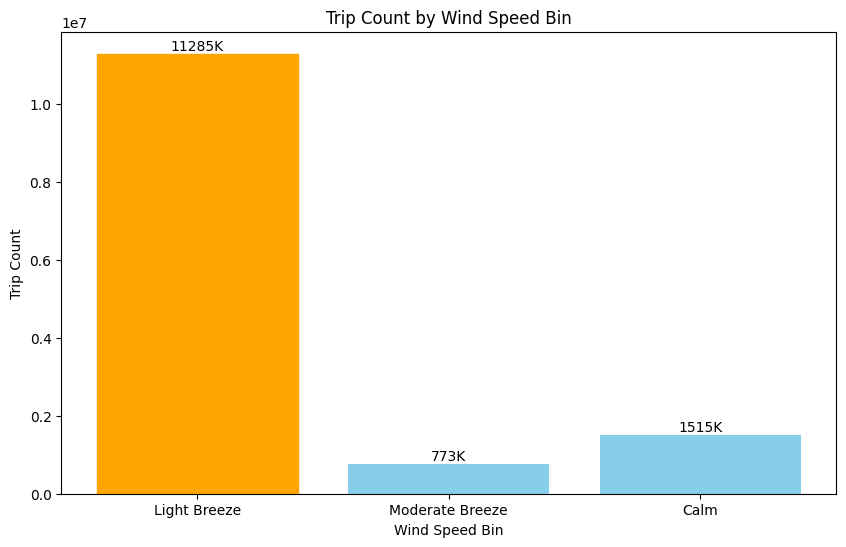

In [137]:
# 바람 세기 구간 별 평균 여행객 수 계산
merged_df = merged_df.withColumn(
    'wind_bin',
    F.when(F.col('Avg_wind_power(m/s)') < 1, 'Calm')
     .when((F.col('Avg_wind_power(m/s)') >= 1) & (F.col('Avg_wind_power(m/s)') < 5), 'Light Breeze')
     .when((F.col('Avg_wind_power(m/s)') >= 5) & (F.col('Avg_wind_power(m/s)') < 10), 'Moderate Breeze')
     .when((F.col('Avg_wind_power(m/s)') >= 10) & (F.col('Avg_wind_power(m/s)') < 15), 'Strong Breeze')
     .otherwise('Gale')
)

# 그룹화
wind_bin_trip_count = merged_df.groupBy('wind_bin').agg(
    F.count('hvfhs_license_num').alias('trip_count')
)

wind_bin_trip_count_data = wind_bin_trip_count.collect()

# 데이터 추출
wind_bins = [row['wind_bin'] for row in wind_bin_trip_count_data]
trip_counts = [row['trip_count'] for row in wind_bin_trip_count_data]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(wind_bins, trip_counts, color='skyblue')
plt.xlabel('Wind Speed Bin')
plt.ylabel('Trip Count')
plt.title('Trip Count by Wind Speed Bin')

# 수치화
max_count = max(trip_counts)
peak = [wind_bins[i] for i in range(len(trip_counts)) if trip_counts[i] == max_count]

# Annotate the bars and highlight peak hours
for i in range(len(wind_bins)):
    plt.text(wind_bins[i], trip_counts[i], str(round(trip_counts[i]/1000)) + 'K', ha='center', va='bottom')
    if wind_bins[i] in peak:
        plt.gca().patches[i].set_color('orange')

plt.show()